<a href="https://colab.research.google.com/github/sechien/world_cup_simulator/blob/main/wc2022_simulator_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
from os.path import join
from google.colab import drive
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import poisson
import tkinter as tk
from tkinter import filedialog
import fnmatch
import plotly.express as px
import io
import requests
import math
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_goals(team1, team2):
  team1_off= team1["off"]
  team1_def= team1["def"]
  team1_home= team1["home"]
  team1_league_average= team1["league_average"]
  team1_confed= team1["confed"]

  team2_off= team2["off"]
  team2_def= team2["def"]
  team2_home= team2["home"]
  team2_league_average= team2["league_average"]
  team2_confed= team2["confed"]
  
  # Thee formula for expected goals scored is: 
  # Off * (opponent's Def) * (home field adjustment) / (league average)
  # from reddit

  t1_pscore= (team1_off*team2_def*team1_home)/team1_league_average 
  t2_pscore= (team2_off*team1_def*team2_home)/team2_league_average

  t1_poi = [poisson.cdf(k=0.5, mu=t1_pscore), 
            poisson.cdf(k=1.5, mu=t1_pscore)- poisson.cdf(k=0.5, mu=t1_pscore),
            poisson.cdf(k=2.5, mu=t1_pscore)- poisson.cdf(k=1.5, mu=t1_pscore),
            poisson.cdf(k=3.5, mu=t1_pscore)- poisson.cdf(k=2.5, mu=t1_pscore),
            poisson.cdf(k=4.5, mu=t1_pscore)- poisson.cdf(k=3.5, mu=t1_pscore),
            poisson.cdf(k=5.5, mu=t1_pscore)- poisson.cdf(k=4.5, mu=t1_pscore)+(1-poisson.cdf(k=5.5, mu=t1_pscore))]

  t2_poi = [poisson.cdf(k=0.5, mu=t2_pscore),
            poisson.cdf(k=1.5, mu=t2_pscore)- poisson.cdf(k=0.5, mu=t2_pscore),
            poisson.cdf(k=2.5, mu=t2_pscore)- poisson.cdf(k=1.5, mu=t2_pscore),
            poisson.cdf(k=3.5, mu=t2_pscore)- poisson.cdf(k=2.5, mu=t2_pscore),
            poisson.cdf(k=4.5, mu=t2_pscore)- poisson.cdf(k=3.5, mu=t2_pscore),
            poisson.cdf(k=5.5, mu=t2_pscore)- poisson.cdf(k=4.5, mu=t2_pscore)+(1-poisson.cdf(k=5.5, mu=t2_pscore))]

  t1_len= len(t1_poi)
  t2_len= len(t2_poi)

  mat_score = np.zeros((t1_len, t2_len))
  mat_result = np.zeros((t1_len, t2_len))
  mat_count = 0
  for i in range(t2_len): 
    for j in range(t1_len):
      mat_score[i, j] = t2_poi[i]*t1_poi[j] #round(t2_poi[i]*t1_poi[j],2)
      mat_result[i, j] =  mat_count
      mat_count +=1

  rng = np.random.default_rng()
  predit_pos= rng.choice(a=mat_result.flatten(), size=None, p=mat_score.flatten())
  team1_goals = int(predit_pos%t1_len)
  team2_goals = math.floor(predit_pos/t1_len)
  match_goals=[team1_goals, team2_goals]
  return match_goals

def group_match_result(matches, match_id):
  team1_str= matches.iloc[match_id]['team1']
  team2_str= matches.iloc[match_id]['team2']
  
  team1 = globals()[team1_str]
  team2 = globals()[team2_str]
  
  match_goals=calculate_goals(team1, team2)
  team1_goals = match_goals[0]
  team2_goals = match_goals[1]

  # points
  if team1_goals > team2_goals:
    team1["points"]+=3
    matches.at[match_id,'result']='team1 wins'
  elif team1_goals < team2_goals:
    team2["points"]+=3
    matches.at[match_id,'result']='team2 wins'
  else:
    team1["points"]+=1
    team2["points"]+=1
    matches.at[match_id,'result']='draw'
  # GD
  team1["goals"]= team1["goals"]+ team1_goals
  team2["goals"]= team2["goals"]+ team2_goals
  team1["gd"]= team1["gd"]+ team1_goals-team2_goals
  team2["gd"]= team2["gd"]+ (team1_goals-team2_goals)*-1
  
  # results 
  matches.at[match_id,'team1_goals']= team1_goals
  matches.at[match_id,'team2_goals']= team2_goals
  del team1, team2

def mk_group_table(t1, t2, t3, t4):
  table= {'ID': [t1['team_id'],t2['team_id'],t3['team_id'],t4['team_id']],
      'Nation': [t1['nation'],t2['nation'],t3['nation'],t4['nation']], 
      'Points':[t1['points'],t2['points'],t3['points'],t4['points']], 
      'GD':[t1['gd'],t2['gd'],t3['gd'],t4['gd']], 
      'Goals':[t1['goals'],t2['goals'],t3['goals'],t4['goals']],
      'Rank':[t1['rank'],t2['rank'],t3['rank'],t4['rank']]}
  df= pd.DataFrame(data=table)
  df.sort_values(by=['Points','GD','Goals','Rank'], ascending = [False,False,False,True], inplace=True, ignore_index=True)
  return df

def knockout_stage_result(teams, matches, match_id):
  # 18 finals results
  team1_code= matches.iloc[match_id]['team1']
  team2_code= matches.iloc[match_id]['team2']
  team1 = globals()[teams[team1_code]]
  team2 = globals()[teams[team2_code]]

  team1_goals=0
  team2_goals=0

  while team1_goals == team2_goals:
    match_goals=calculate_goals(team1, team2)
    team1_goals = match_goals[0]
    team2_goals = match_goals[1]

  matches.at[match_id,'team1_goals']= team1_goals
  matches.at[match_id,'team2_goals']= team2_goals

  if team1_goals > team2_goals:
    matches.at[match_id,'result']= 'team1 wins'#team1['team_id']
    matches.at[match_id,'win']= team1['team_id']
    matches.at[match_id,'lose']= team2['team_id']
  elif team1_goals < team2_goals:
    matches.at[match_id,'result']= 'team2 wins' #team2['team_id']
    matches.at[match_id,'win']= team2['team_id']
    matches.at[match_id,'lose']= team1['team_id']
  else:
    matches.at[match_id,'result']= 'should not happen'
  
  del team1, team2

  
def simulator():  
  '''
  url="https://projects.fivethirtyeight.com/soccer-api/international/spi_global_rankings_intl.csv"
  s=requests.get(url).content
  spi_data=pd.read_csv(io.StringIO(s.decode('utf-8')))

  # schedule
  
  matches['team1_goals']=''
  matches['team2_goals']=''
  matches['result']=''
  # team id
  teams = pd.read_csv("/content/gdrive/MyDrive/teams.csv")
  '''
  # data stracture 
  # A1 = a dictionary with data of the a1 team in group a
  # Example: A1 = {"nation": "Qatar", "off": 1.66, "def": 1.09, "home": 1.11, "leagure_average": 1.3, "confed"="AFC"}
  for team_id in teams['team']:
    nation = teams[teams['team']==team_id]['name'].iloc[0]
    if nation == 'Qatar': home_w = 1.11
    else: home_w = 1
    globals()[team_id] = {"nation": nation,
               "team_id": team_id,            
               "off": spi_data[spi_data['name']==nation]['off'].iloc[0],
               "def":  spi_data[spi_data['name']==nation]['def'].iloc[0],
               'spi': spi_data[spi_data['name']==nation]['spi'].iloc[0],
               "home": home_w, 
               "league_average": 1.3, 
               "confed": spi_data[spi_data['name']==nation]['confed'].iloc[0],
               "rank": spi_data[spi_data['name']==nation]['rank'].iloc[0],
               "points": 0,
               "gd":0,
               "goals":0
               }  
  
  matches_group = matches[matches['stage']=='group']
  matches_18=matches[matches['stage']=='18_finals'].reset_index(drop=True)
  matches_18['win']=''
  matches_18['lose']=''
  matches_14=matches[matches['stage']=='14_finals'].reset_index(drop=True)
  matches_14['win']=''
  matches_14['lose']=''
  matches_semi=matches[matches['stage']=='semi_finals'].reset_index(drop=True)
  matches_semi['win']=''
  matches_semi['lose']=''
  matches_last=matches[(matches['stage']=='third') | (matches['stage']=='final')] .reset_index(drop=True)
  matches_last['win']=''
  matches_last['lose']=''
  #simu_num=[]
  first_list = []
  second_list = []
  third_list= []
  fourth_list= []

  for i in range(len(matches_group)):
    group_match_result(matches_group, i)

  adv_team={}
  group_a = mk_group_table(A1, A2, A3, A4)
  adv_team['1A']=group_a['ID'][0]
  adv_team['2A']=group_a['ID'][1]
  group_b = mk_group_table(B1, B2, B3, B4)
  adv_team['1B']=group_b['ID'][0]
  adv_team['2B']=group_b['ID'][1]
  group_c = mk_group_table(C1, C2, C3, C4)
  adv_team['1C']=group_c['ID'][0]
  adv_team['2C']=group_c['ID'][1]
  group_d = mk_group_table(D1, D2, D3, D4)
  adv_team['1D']=group_d['ID'][0]
  adv_team['2D']=group_d['ID'][1]
  group_e = mk_group_table(E1, E2, E3, E4)
  adv_team['1E']=group_e['ID'][0]
  adv_team['2E']=group_e['ID'][1]
  group_f = mk_group_table(F1, F2, F3, F4)
  adv_team['1F']=group_f['ID'][0]
  adv_team['2F']=group_f['ID'][1]
  group_g = mk_group_table(G1, G2, G3, G4)
  adv_team['1G']=group_g['ID'][0]
  adv_team['2G']=group_g['ID'][1]
  group_h = mk_group_table(H1, H2, H3, H4)
  adv_team['1H']=group_h['ID'][0]
  adv_team['2H']=group_h['ID'][1]

  # 18 finals results
  for i in range(len(matches_18)):
    knockout_stage_result(adv_team, matches_18,i)

  teams_14={}
  teams_14['W49']=matches_18['win'][0]
  teams_14['W50']=matches_18['win'][1]
  teams_14['W51']=matches_18['win'][2]
  teams_14['W52']=matches_18['win'][3]
  teams_14['W53']=matches_18['win'][4]
  teams_14['W54']=matches_18['win'][5]
  teams_14['W55']=matches_18['win'][6]
  teams_14['W56']=matches_18['win'][7]

  # 14 finals results
  for i in range(len(matches_14)):
    knockout_stage_result(teams_14, matches_14,i)

  teams_semi={}
  teams_semi['W57'] = matches_14['win'][0]
  teams_semi['W58'] = matches_14['win'][1]
  teams_semi['W59'] = matches_14['win'][2]
  teams_semi['W60'] = matches_14['win'][3]

  # semi finals results
  for i in range(len(matches_semi)):
    knockout_stage_result(teams_semi, matches_semi,i)

  teams_final={}
  teams_final['W61'] = matches_semi['win'][0]
  teams_final['W62'] = matches_semi['win'][1]
  teams_final['L61'] = matches_semi['lose'][0]
  teams_final['L62'] = matches_semi['lose'][1]

  # final results
  for i in range(len(matches_last)):
    knockout_stage_result(teams_final, matches_last,i)

  third_place = globals()[matches_last['win'][0]]
  fourth_place = globals()[matches_last['lose'][0]]
  second_place = globals()[matches_last['lose'][1]]
  first_place = globals()[matches_last['win'][1]]

  #simu_num.append(1)
  first_list.append(first_place['nation'])
  second_list.append(second_place['nation'])
  third_list.append(third_place['nation'])
  fourth_list.append(fourth_place['nation'])

  wc_results = {'winner': first_list, 'second place': second_list, 
                'third place': third_list, 'fourth place': fourth_list}
  df_wc_results = pd.DataFrame(data=wc_results)
  simu_output= {'final_four': df_wc_results, 'group_a': group_a, 'group_b': group_b,
                  'group_c': group_c, 'group_d': group_d, 'group_e': group_e,
                  'group_f': group_f, 'group_g': group_g, 'group_h': group_h,
                  'matches_group': matches_group
                 }
  return simu_output
  #return df_wc_results

if __name__=='__main__':
  drive.mount('/content/gdrive') # need to login Google account
  num_simu = 50000
  global matches 
  matches = pd.read_csv("/content/gdrive/MyDrive/matches.csv")
  url="https://projects.fivethirtyeight.com/soccer-api/international/spi_global_rankings_intl.csv"
  s=requests.get(url).content
  spi_data=pd.read_csv(io.StringIO(s.decode('utf-8')))

  # schedule
  matches['team1_goals']=''
  matches['team2_goals']=''
  matches['result']=''
  # team id
  teams = pd.read_csv("/content/gdrive/MyDrive/teams.csv")
  
  total_results = pd.DataFrame()
  group_matches_results = pd.DataFrame()
  g_a_result = pd.DataFrame()
  g_b_result = pd.DataFrame()
  g_c_result = pd.DataFrame()
  g_d_result = pd.DataFrame()
  g_e_result = pd.DataFrame()
  g_f_result = pd.DataFrame()
  g_g_result = pd.DataFrame()
  g_h_result = pd.DataFrame()
  for i in range(num_simu):
    simu_result_temp= simulator()
    total_results=pd.concat([total_results, simu_result_temp['final_four']], ignore_index=True)
    group_matches_results= pd.concat([group_matches_results, simu_result_temp['matches_group']], ignore_index=True)
    g_a_result=pd.concat([g_a_result, simu_result_temp['group_a'].drop(['Rank'], axis=1)], ignore_index=True)
    g_b_result=pd.concat([g_b_result, simu_result_temp['group_b'].drop(['Rank'], axis=1)], ignore_index=True)
    g_c_result=pd.concat([g_c_result, simu_result_temp['group_c'].drop(['Rank'], axis=1)], ignore_index=True)
    g_d_result=pd.concat([g_d_result, simu_result_temp['group_d'].drop(['Rank'], axis=1)], ignore_index=True)
    g_e_result=pd.concat([g_e_result, simu_result_temp['group_e'].drop(['Rank'], axis=1)], ignore_index=True)
    g_f_result=pd.concat([g_f_result, simu_result_temp['group_f'].drop(['Rank'], axis=1)], ignore_index=True)
    g_g_result=pd.concat([g_g_result, simu_result_temp['group_g'].drop(['Rank'], axis=1)], ignore_index=True)
    g_h_result=pd.concat([g_h_result, simu_result_temp['group_h'].drop(['Rank'], axis=1)], ignore_index=True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# final four combined results
winner_count=total_results['winner'].value_counts().to_dict()
second_count=total_results['second place'].value_counts().to_dict()
third_count=total_results['third place'].value_counts().to_dict()
fourth_count=total_results['fourth place'].value_counts().to_dict()

col_winner_count=pd.DataFrame.from_dict(winner_count, orient='index', columns=['winner'])
col_second_count=pd.DataFrame.from_dict(second_count, orient='index', columns=['second place'])
col_third_count=pd.DataFrame.from_dict(third_count, orient='index', columns=['third place'])
col_fourth_count=pd.DataFrame.from_dict(fourth_count, orient='index', columns=['fourth place'])
table_finalfour_count= pd.concat([col_winner_count, col_second_count, col_third_count, col_fourth_count], axis=1).fillna(0)
# test_table =pd.concat([c_a, c_b, c_c, c_d], axis=1).fillna(0)
table_len= len(table_finalfour_count)
win_index_list=[]
for i in range(table_len):
  win_index = ((table_finalfour_count.iloc[i]['winner']*4)
                +(table_finalfour_count.iloc[i]['second place']*3)
                +(table_finalfour_count.iloc[i]['third place']*2)+(table_finalfour_count.iloc[i]['fourth place']))/num_simu
  win_index_list.append(win_index)

wi_array=np.asarray(win_index_list)
table_finalfour_count.insert(len(table_finalfour_count.columns), 'winning index',  win_index_list)
table_finalfour_count.sort_values(by=['winning index'], ascending = [False], inplace=True)
table_finalfour_count

,winner,second place,third place,fourth place,winning index
Brazil,19223,5297,4500,1037,2.05640
Spain,6562,4953,3614,1754,1.00178
France,4333,4916,5414,3473,0.92762
Portugal,4131,4926,3270,2168,0.80020
Argentina,2797,3398,5065,3687,0.70398
Netherlands,2377,3239,5074,4174,0.67094
England,1894,3165,3609,3487,0.55552
Germany,1762,2942,2191,2169,0.44850
Denmark,1105,2093,2596,3018,0.37818
Uruguay,1198,2085,1621,1677,0.31932


In [ ]:
# group stage combined results
a_mean_result = g_a_result.groupby(by=["Nation"]).mean()
b_mean_result = g_b_result.groupby(by=["Nation"]).mean()
c_mean_result = g_c_result.groupby(by=["Nation"]).mean()
d_mean_result = g_d_result.groupby(by=["Nation"]).mean()
e_mean_result = g_e_result.groupby(by=["Nation"]).mean()
f_mean_result = g_f_result.groupby(by=["Nation"]).mean()
g_mean_result = g_g_result.groupby(by=["Nation"]).mean()
h_mean_result = g_h_result.groupby(by=["Nation"]).mean()

a_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
b_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
c_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
d_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
e_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
f_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
g_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)
h_mean_result.sort_values(by=['Points','GD','Goals'], ascending = [False,False,False], inplace=True)

In [ ]:
def draw_barchart(font_color, figure_color, index, x_label, x_max):
  table_finalfour_count.sort_values(by=[index], ascending = [False], inplace=True)
  plt.rcParams['font.family'] = 'sans-serif'
  plt.rcParams['font.sans-serif'] = 'Helvetica'
  # set the style of the axes and the text color
  plt.rcParams['axes.edgecolor']=font_color
  plt.rcParams['axes.linewidth']=0.8
  plt.rcParams['xtick.color']=font_color
  plt.rcParams['ytick.color']=font_color
  plt.rcParams['text.color']=font_color

  my_range=list(range(1,11+1))
  #fig, ax = plt.subplots(figsize=(5,3.5))
  fig, ax = plt.subplots(figsize=(8,4.5))
  plt.hlines(y=my_range, xmin=0, xmax=table_finalfour_count[index], color=figure_color, alpha=0.2, linewidth=5)
  plt.plot(table_finalfour_count[index][0:11], my_range, "o", markersize=5, color=figure_color, alpha=0.6)

  # set labels
  ax.set_xlabel(x_label, fontsize=18, fontweight='black', color = font_color)
  ax.set_ylabel('')

  # set axis
  ax.tick_params(axis='both', which='major', labelsize=16)
  plt.yticks(my_range, table_finalfour_count.index)

  # add an horizonal label for the y axis 
  fig.text(-0.23, 0.96, 'TEAM', fontsize=18, fontweight='black', color = font_color)

  # change the style of the axis spines
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  ax.spines['left'].set_bounds((1, len(my_range)))
  ax.set_xlim(0,x_max)

  ax.spines['left'].set_position(('outward', 16))
  ax.spines['bottom'].set_position(('outward', 10))

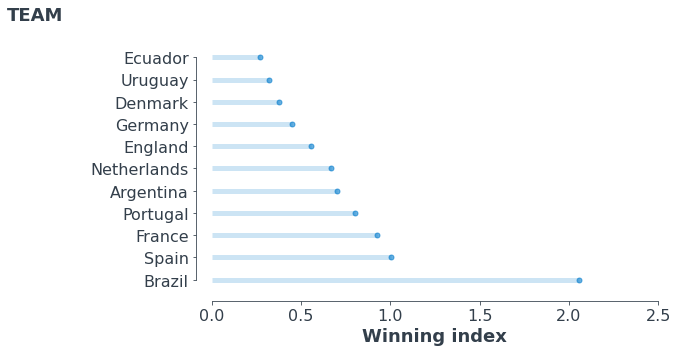

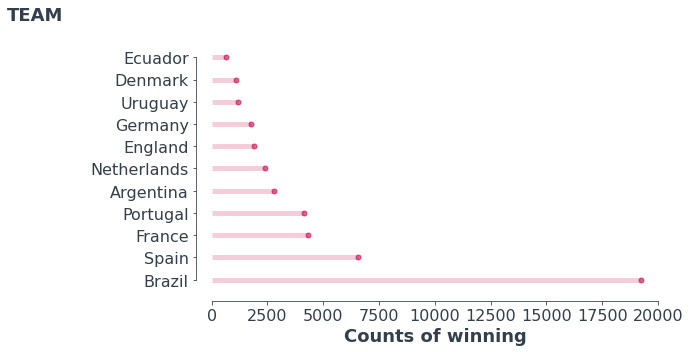

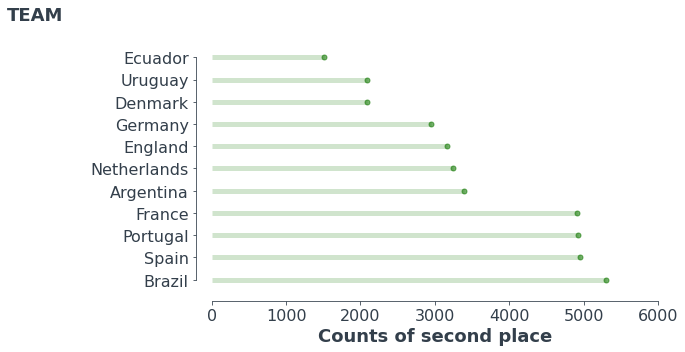

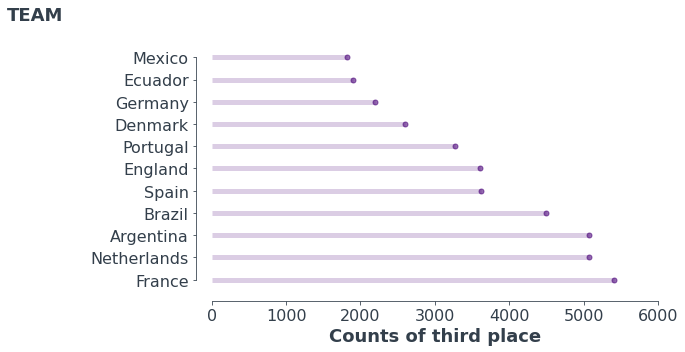

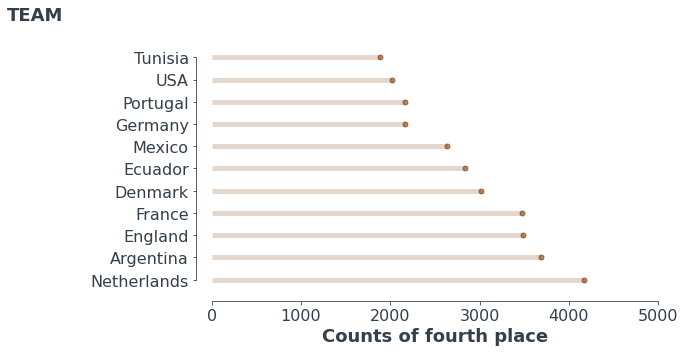

In [ ]:
draw_barchart('#333F4B', '#007ACC', 'winning index', 'Winning index',2.5)
draw_barchart('#333F4B', '#cc0047', 'winner', 'Counts of winning',20000)
draw_barchart('#333F4B', '#157a05', 'second place', 'Counts of second place',6000)
draw_barchart('#333F4B', '#4b057a', 'third place', 'Counts of third place',6000)
draw_barchart('#333F4B', '#7a3805', 'fourth place', 'Counts of fourth place',5000)


In [ ]:
group_matches_results = group_matches_results.drop(['result'], axis=1)

In [ ]:
mean_group_result = group_matches_results.groupby(by=["Match","team1","team2"]).mean()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mean_group_result

,,,team1_goals,team2_goals
Match,team1,team2,,
1,A1,A2,0.78954,1.69502
2,A3,A4,0.80632,1.82880
3,B1,B2,1.21804,0.65178
4,B3,B4,1.21400,0.91870
5,D1,D2,1.66660,0.58764
6,D3,D4,1.02552,0.80090
7,C3,C4,1.22042,0.80660
8,C1,C2,1.46504,0.53740
9,F1,F2,1.45654,1.05754


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/mean_group_result_5K.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  mean_group_result.to_csv(f)




Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/a_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  a_mean_result.to_csv(f)

In [ ]:
b_mean_result

,Points,GD,Goals
Nation,,,
England,5.41995,1.76265,3.93905
USA,4.05005,-0.00535,3.06865
Iran,3.51665,-0.64865,2.43750
Wales,3.20935,-1.10865,2.45195


In [ ]:
path = '/content/drive/MyDrive/b_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  b_mean_result.to_csv(f)

path = '/content/drive/MyDrive/c_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  c_mean_result.to_csv(f)

path = '/content/drive/MyDrive/d_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  d_mean_result.to_csv(f)

path = '/content/drive/MyDrive/e_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  e_mean_result.to_csv(f)

path = '/content/drive/MyDrive/f_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  f_mean_result.to_csv(f)

path = '/content/drive/MyDrive/g_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  g_mean_result.to_csv(f)

path = '/content/drive/MyDrive/h_mean_result_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  h_mean_result.to_csv(f)

In [ ]:
path = '/content/drive/MyDrive/table_finalfour_count_50k.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  table_finalfour_count.to_csv(f)

#table_finalfour_count

In [ ]:
g_mean_result

,Points,GD,Goals
Nation,,,
Brazil,6.96876,3.93640,5.12704
Switzerland,3.80776,-0.41066,2.94088
Serbia,3.50662,-0.88974,2.87102
Cameroon,2.21334,-2.63600,1.83350


In [ ]:
e_mean_result

,Points,GD,Goals
Nation,,,
Spain,6.30416,3.07338,4.93888
Germany,5.20576,1.71896,4.90246
Japan,3.43768,-1.07366,3.20640
Costa Rica,1.68866,-3.71868,1.79998
